<a href="https://colab.research.google.com/github/AIAlchemy1/Generative-AI/blob/main/06_Language_Modelling_RNN_LSTM/RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Modeling With RNN and LSTM

Large number of NLP applications today are based on language models. Language modeling aims to predict the next word in a word sequence or estimate the likelihood of a word sequence.

Let's train RNN language models and try to use them for text generation.

In [7]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.9 MB/s eta 0:00:00


We will train language model based on movie reviews from popular IMDB dataset. The dataset could be downloaded using `datasets` library.

In [8]:
import datasets

In [9]:
from datasets import load_dataset

dataset_reviews = load_dataset("imdb", split='train')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [10]:
dataset_reviews

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

The dataset is labeled for text classification task so is contains texts and corresponding labels but for training a language model we will only need texts.

In [11]:
dataset_reviews['text'][:5]

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

## Data Preprocessing

Language models predict next token in the sequence so we need to split texts into tokens. Token could correspond to a word or a part of word. Transformer-based models use subword tokenization but RNN language models usually work with tokens representing full words or individual characters. We will use word-level tokenization.

To implement text preprocessing we can apply tokenizers from `nltk` library. As the result we will get a list of tokens for the input text. Note that preprocessing should keep everything that you would like to see in the generated text (for example, if you filter out punctuation then generated texts would not contain punctiation marks).

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
from nltk.tokenize import word_tokenize

def preprocess(item):
  tokens = word_tokenize(item['text'].replace('<br />', ' ').replace('\\', ' '))
  item['tokens'] = tokens
  return item


In [14]:
tokenized_reviews = dataset_reviews.map(preprocess, remove_columns=['text'])

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [15]:
len(tokenized_reviews)

25000

In [16]:
tokenized_reviews[0]['tokens'][:25]

['I',
 'rented',
 'I',
 'AM',
 'CURIOUS-YELLOW',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967',
 '.']

Next step we need to create a custom dataset that will prepare our data for the training of a language model. The model will read the input sequence and produce the next token in a sequence. So training sample should contain sequence of tokens as an input and the same  sequence shifted on one token to the right as an ouput.

Input: $x_0, x_1, x_2, ... x_k$

Ouput: $x_1, x_2, x_3, ... x_{k+1}$

To build a dataset we will join all the tokenized texts together adding special end-of-sequence token `<eos>` in the end of each text. Apart from this token we will add to the vocabulary a special token for unknown words `<unk>`.

Dataset class should contain two methods:
 - `__len__`: to get the size of the dataset,
 - `__getitem__`: to get an item of the dataset by the item's index.

We will also need additional methods to build a vocabulary and collect corpus of dataset's tokenized texts joined together. Then the corpus will be split into dataset's items of fixed length.

In [17]:
import torch

class TextsDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        texts,
        seq_len,
    ):
        self.seq_len = seq_len
        self.vocab = self.build_vocab(texts)

        self.id_to_word = {index: word for index, word in enumerate(self.vocab)}
        self.word_to_id = {word: index for index, word in enumerate(self.vocab)}

        self.corpus = self.build_corpus(texts)

    def build_vocab(self, texts):
        return ['<unk>', '<eos>'] + list(set([token for text_tokens in texts for token in text_tokens]))

    def build_corpus(self, texts):
      corpus = []
      for text in texts:
        tokens = [self.word_to_id[word] for word in text] + [self.word_to_id['<eos>']]
        corpus.extend(tokens)
      return corpus

    def __len__(self):
        return len(self.corpus) // self.seq_len

    def __getitem__(self, index):
      item_start = index * self.seq_len
      return (
            torch.tensor(self.corpus[item_start:item_start + self.seq_len]),
            torch.tensor(self.corpus[item_start + 1: item_start + self.seq_len + 1]),
        )

In [18]:
# sequence length for dataset item
SEQ_LEN = 150
reviews_texts_dataset = TextsDataset(tokenized_reviews['tokens'], SEQ_LEN)

In [19]:
# size of vocabulary
len(reviews_texts_dataset.vocab)

123381

In [20]:
# mapping to get word id
reviews_texts_dataset.word_to_id['sport']

109639

In [21]:
reviews_texts_dataset.word_to_id['<eos>']

1

Here we can see an example of dataset item: pair of tokenized sequences, each element of the second sequence is the next token for this position in the first sequence.

In [22]:
reviews_texts_dataset[0]

(tensor([110556,  95305, 110556,  79584, 118577,  53166,  47218,  11160,  62797,
          87345,  78571,  47530,  17949,   5558,  37079,  52541,  73046,  16558,
          73046,  12548,  34848,  86244,  79089, 108373,  70460, 110556,  80139,
          12849,  37079, 106166,  34848,  73046,  12548,  83782,  47562, 122509,
          23121,  19756,  73046,  65026,  63750,   8248,  29559, 101661,  56430,
          70141,  81972, 111444, 121475,  90735,  78571,  95626,  86230,  37450,
          30161,  37743, 110556,  95373,  66096,   8248,  19869, 101661,  13516,
          83384,  70460,  67148,   8710, 104494, 102054,  98867, 121475,  94710,
          73253, 116797,  28517,  95686,  68952,  83621,  58376,   8248, 102354,
          58562,  42989,  91940,  76376,  51441,  70460,  66994,  61054,  42989,
          58376,   8248,  38739, 110072,  13881,   8248,  63916,  34155,  25549,
          78571,   5589,  21337,  44890,  17949,  74042, 111813,    215,  76376,
          56258, 103624,  59

Let's split the data into train and validation subsets for training and evaluation of the model.

In [23]:
from torch.utils.data import random_split
reviews_train, reviews_val = random_split(reviews_texts_dataset, [0.8, 0.2])

In [24]:
len(reviews_texts_dataset)

44798

In [25]:
len(reviews_train), len(reviews_val)

(35839, 8959)

## RNN Model

RNN model processes one token at a time reading an input sequence left to right, and at each step current hidden state vector is passed to the next step.
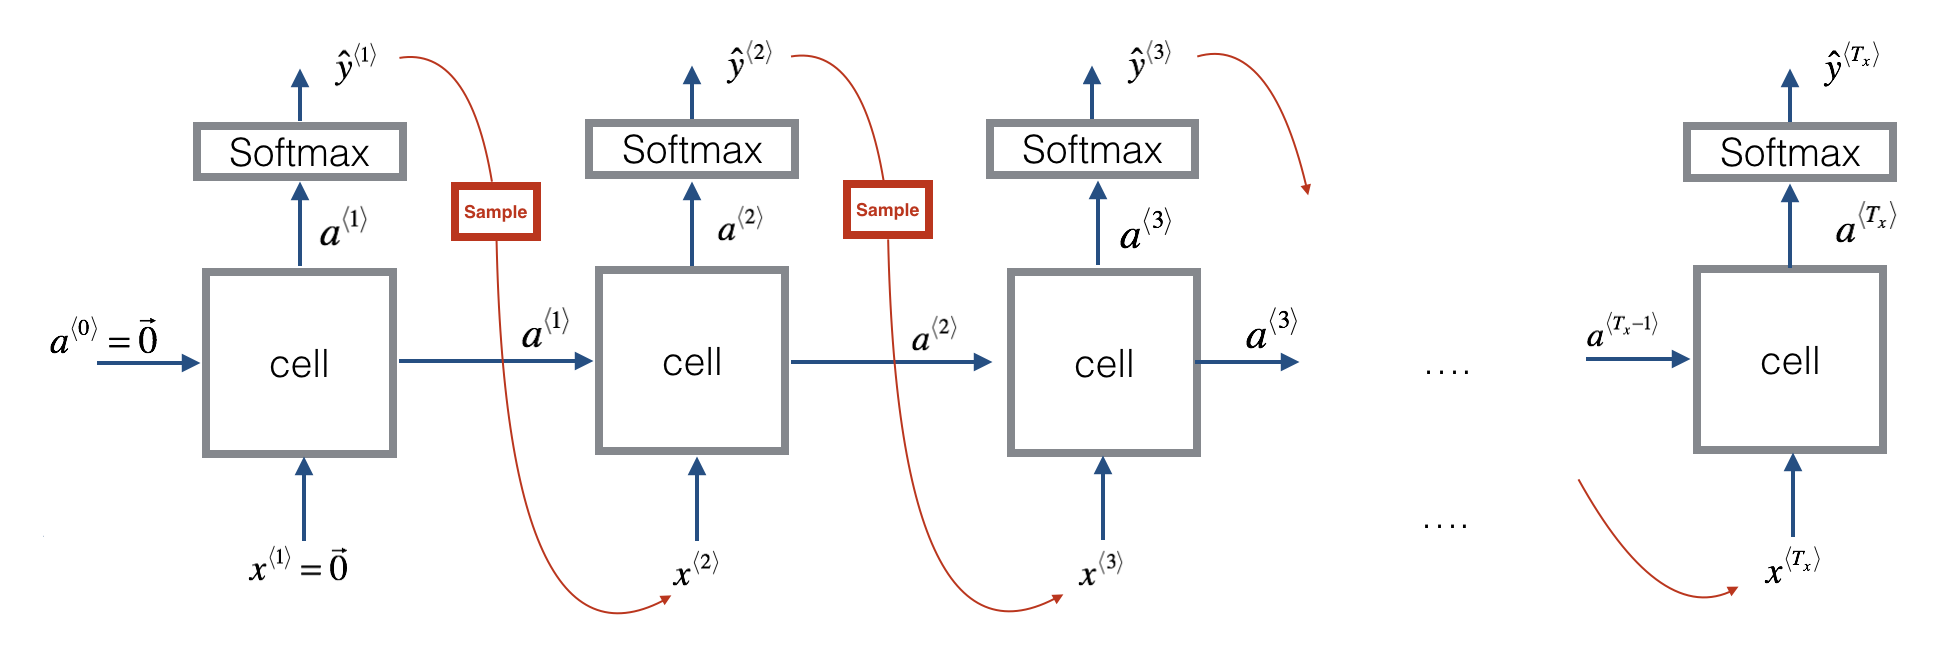

$$x_{1:n} = x_1, x_2, \ldots, x_n$$

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$


RNN model will consist of the following layers:
- Embedding layer that transforms the indices of input tokens into vector representations of fixed dimension,
- LSTM layers that take embeddings and previous hidden state as an input and return output and new hidden state vector,
- Linear layer that takes LSTM output and produces logits for the next token in the sequence.

Each step the model aims to score all the tokens of the vocabulary to predict the most probable next token for the sequence. This task could be approached as a classification problem: to predict the score for each of the classes where classes stand for the tokens in the vocabulary. So the model is trained with cross-entropy loss.

We also add Dropout after Embedding and LSTM layers. Drouput sets part of the layer's weights to zero while training, which helps to prevent overfitting. The ratio of the weights is defined with `dropout` parameter of the network.


In [26]:
from torch import nn
import math

class RNNModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.num_layers = num_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(self.vocab_size, self.emb_dim)
        self.lstm = nn.LSTM(self.emb_dim, self.hidden_dim, num_layers=self.num_layers, dropout=self.dropout, batch_first=True)
        self.dropout = nn.Dropout(self.dropout)
        self.fc = nn.Linear(self.hidden_dim, self.vocab_size)

    def forward(self, src, hidden):
        embedding = self.dropout(self.embedding(src))
        output, hidden = self.lstm(embedding, hidden)
        output = self.dropout(output)
        logits = self.fc(output)
        return logits, hidden

    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return hidden, cell

Now we need to set the parameters of the model.

In [27]:
VOCAB_SIZE = len(reviews_texts_dataset.vocab) # size of vocabulary (input of embedding layer)
EMB_DIM = 100                                 # embedding dimension (output of embedding layer)
HIDDEN_DIM = 256                              # hidden state dimension
NUM_LAYERS = 2                                # number of LSTM layers
DROPOUT = 0.5                                 # dropout probability
LR = 1e-3                                     # learning rate

In [28]:
BATCH_SIZE = 32

Training models in PyTorch requires the model and the data tensors to be located on the same device. To provide training on the GPU we set device type as `cuda` if it's available or `cpu` otherwise.

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Next we initialize the model and set loss function and optimizer for training.

In [30]:
model = RNNModel(VOCAB_SIZE, EMB_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT).to(device)

In [31]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

We will use `DataLoader` to split the datasets into batches and create iterators for training. Parameter `drop_last` allows to drop the last batch if it contains less examples than batch size.

In [32]:
from torch.utils.data import DataLoader
from torch import nn, optim

train_dataloader = DataLoader(
        reviews_train,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True
    )

val_dataloader = DataLoader(
        reviews_val,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True
    )

In [33]:
len(train_dataloader)

1119

Let's implement functions for training and evaluation on one epoch.

Training requires the `train` mode for the model as dropout will be activated only in train mode. Then we initialize hidden state and start interation over batches. Each iteration includes getting output and hidden state for the input and previous hidden state value, gradients calculation and backpropagation step.

PyTorch accumulates gradients on backward passes so we need to set gradients to zero with `zero_grad` metod before starting backpropagation on each batch.

To process long-term memory dependancies, LSTM network uses cell state in addition to hidden state that stores information from immediately previous events.

For evaluation we set the model in `eval` mode, get the model prediction for the input and previous hidden state and calculate loss.

In [34]:
def train(model, dataloader):
    epoch_loss = 0
    model.train()

    hidden_state, cell_state = model.init_hidden(BATCH_SIZE, device)

    for batch, (x, y) in enumerate(dataloader):

      x = x.to(device)
      y = y.to(device)

      optimizer.zero_grad() # set gradients to zero before batch processing

      pred, (hidden_state, cell_state) = model(x, (hidden_state, cell_state))
      loss = criterion(pred.transpose(1, 2), y)

      hidden_state = hidden_state.detach()
      cell_state = cell_state.detach()

      loss.backward() # compute loss gradients
      optimizer.step() # update parameters in backpropagation
      epoch_loss += loss.item()

      if batch%200==0:
        print({'batch': batch, 'loss': loss.item()})
    return epoch_loss / batch

def evaluate(model, dataloader):
    epoch_loss = 0
    model.eval()

    hidden_state, cell_state = model.init_hidden(BATCH_SIZE, device)

    with torch.no_grad():
        for batch, (x, y) in enumerate(dataloader):
          hidden_state = hidden_state.detach()
          cell_state = cell_state.detach()
          x = x.to(device)
          y = y.to(device)
          pred, (hidden_state, cell_state) = model(x, (hidden_state, cell_state))
          loss = criterion(pred.transpose(1, 2), y)

          epoch_loss += loss.item()
    return epoch_loss / batch

Now we can run training loop for several epochs. Aftre each epoch the model is saved if the new loss on validation dataset was lower then the one in the previous epoch.

In [35]:
%%time
NUM_EPOCHS = 3
best_val_loss = -1

for epoch in range(NUM_EPOCHS):
    train_loss = train(model, train_dataloader)
    val_loss = evaluate(model, val_dataloader)
    print({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})

    if best_val_loss < 0 or val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'rnn_lm.pt')
        print('Saving model')

    print(f'\ttrain_perplexity: {math.exp(train_loss):.3f}')
    print(f'\tval_perplexity: {math.exp(val_loss):.3f}')


{'batch': 0, 'loss': 11.728246688842773}
{'batch': 200, 'loss': 7.296552658081055}
{'batch': 400, 'loss': 7.061327934265137}
{'batch': 600, 'loss': 6.94985818862915}
{'batch': 800, 'loss': 6.673106670379639}
{'batch': 1000, 'loss': 6.509336948394775}
{'epoch': 0, 'train_loss': 6.959677505578466, 'val_loss': 6.268871122126956}
Saving model
	train_perplexity: 1053.294
	val_perplexity: 527.881
{'batch': 0, 'loss': 6.526071548461914}
{'batch': 200, 'loss': 6.124413967132568}
{'batch': 400, 'loss': 6.1075968742370605}
{'batch': 600, 'loss': 6.198312759399414}
{'batch': 800, 'loss': 6.087850570678711}
{'batch': 1000, 'loss': 6.022391319274902}
{'epoch': 1, 'train_loss': 6.187027454376221, 'val_loss': 5.9210930059282045}
Saving model
	train_perplexity: 486.398
	val_perplexity: 372.819
{'batch': 0, 'loss': 6.145174503326416}
{'batch': 200, 'loss': 5.987916469573975}
{'batch': 400, 'loss': 5.88219690322876}
{'batch': 600, 'loss': 5.989007949829102}
{'batch': 800, 'loss': 5.834740161895752}
{'ba

We can load model from the saved `state_dict` and use it for inference.

In [36]:
PATH = 'rnn_lm.pt'
model_loaded = RNNModel(VOCAB_SIZE, EMB_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT).to(device)
model_loaded.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Now we can try to generate text with the model. The model outputs scores for each token of vocabulary, we apply softmax to get probability distribution for the next token. Then we need to add sampling to choose the next token of the sequence. Here we will use random sampling based on the obtained probabilities.

In [38]:
import numpy as np

def generate(start, max_len, model, id_to_word, word_to_id):
    model.eval()
    tokens = word_tokenize(start)
    unk_id = word_to_id['<unk>']
    ids = [word_to_id.get(t, unk_id) for t in tokens]
    batch_size = 1
    hidden_state, cell_state = model.init_hidden(batch_size, device)
    with torch.no_grad():
        for i in range(max_len):
            x = torch.LongTensor([ids]).to(device)
            pred, (hidden_state, cell_state) = model(x, (hidden_state, cell_state))
            scores = torch.softmax(pred[:, -1], dim=-1)
            output = np.random.choice(np.arange(len(id_to_word)), p=scores.cpu().numpy().ravel())
            while output == word_to_id['<unk>']:
                output = np.random.choice(np.arange(len(id_to_word)), p=scores.cpu().numpy().ravel())

            if output == word_to_id['<eos>']:
                break

            ids.append(output)

    pred_tokens = [id_to_word[id] for id in ids]
    return pred_tokens

Let's have a look at some examples of generated texts using different prefixes.

In [39]:
start = 'Imagine'
max_len = 50

generated = generate(start, max_len, model_loaded, reviews_texts_dataset.id_to_word,
                     reviews_texts_dataset.word_to_id)
' '.join(generated)

"Imagine correct one tension so if he starts as painfully that kind of lovely for what its total different for favorites and playing he dynamic British Goldwyn family , but watching his Monica secs when Dutch knew are n't unknown . A numerous story thriller off allowed getting remembered . What"

In [40]:
start = 'Music'
max_len = 50

generated = generate(start, max_len, model_loaded, reviews_texts_dataset.id_to_word,
                     reviews_texts_dataset.word_to_id)


In [41]:
' '.join(generated)

"Music precedes Albert 's so wife Glasses ( William ) the dead too . The BORING tie been , young low-budget , expression , Jon 's own boy Jackson by the supporting . Rosario ? Now , I 'll think the wrong line I will have some interesting stupid minutes ,"

In [42]:
start = 'Global corporations'
max_len = 50

generated = generate(start, max_len, model_loaded, reviews_texts_dataset.id_to_word,
                     reviews_texts_dataset.word_to_id)


In [43]:
' '.join(generated)

'Global corporations 1960 , if any crazy dialogue . There is the way of people with a intriguing way of the death . One season tolerable , frankly produced ? I think that is scene about striking seemed , at the majority , of Laila they are purely a comedy with them'

In [44]:
start = 'Imagine the story of a man'
max_len = 50

generated = generate(start, max_len, model_loaded, reviews_texts_dataset.id_to_word,
                     reviews_texts_dataset.word_to_id)


In [45]:
' '.join(generated)

"Imagine the story of a man and he 's a very serious line and the damage is so of that Christmas Ariel . it is to keep . Run performances is a married Hartley up that the Total mask ( SXSW Baby , though of the possibly Prichard ) , a sense of gross . Moreover"

In [46]:
start = 'Every time I watch this movie'
max_len = 50

generated = generate(start, max_len, model_loaded, reviews_texts_dataset.id_to_word,
                     reviews_texts_dataset.word_to_id)


In [47]:
' '.join(generated)

"Every time I watch this movie in Iran ... or creepy - just bad that she was the time too to all . This is a startling movie . Unfortunately , I think is his best failed example is a thriller who does n't describe the rest she it takes the Magnificent ; starts something of"

## Perplexity Evaluation

To evaluate language model we can use perplexity measure as it allows to estimate how well the model approximates real probability distribution of tokens in the texts. Smaller perplexity means better performance of language model.

The perplexity of the text is calculated with the following formlula:

$$
    {\mathbb{P}}(w_1 \dots w_N) = P(w_1, \dots, w_N)^{-\frac1N} = \left( \prod_t P(w_t \mid w_{t - n}, \dots, w_{t - 1})\right)^{-\frac1N},
$$
where $N$ is the number of tokens in the text.
Instead of probabilities multiplication we can compute sum of log-probabilities and then take exponent.


In [48]:
def calculate_perplexity(text, model, word_to_id):
    prob = 0
    model.eval()
    tokens = word_tokenize(text)
    unk_id = word_to_id['<unk>']
    ids = [word_to_id.get(t, unk_id) for t in tokens]
    batch_size = 1
    hidden_state, cell_state = model.init_hidden(batch_size, device)
    with torch.no_grad():
        for i in range(len(ids)-1):
            x = torch.LongTensor([ids[:i+1]]).to(device)
            y = ids[i+1]
            pred, (hidden_state, cell_state) = model(x, (hidden_state, cell_state))
            scores = torch.softmax(pred[:, -1], dim=-1).cpu().numpy()
            # print(scores)
            y_prob = scores[0][y]
            prob += np.log(y_prob)

    return np.exp((-1/len(ids)) * prob)

In [49]:
text = 'Largest annual event in IT consulting will take place in December in Lisbon'
perplexity = calculate_perplexity(text, model_loaded, reviews_texts_dataset.word_to_id)


In [50]:
perplexity

2540.238112127088

In [51]:
text = 'The story that happened on this event was shown so dramatic and strong.'
perplexity = calculate_perplexity(text, model_loaded, reviews_texts_dataset.word_to_id)
perplexity


146.2666743596614

Here we can see that first sentence shows much larger perplexity value because it is less typical for the corpus of movie reviews that was used for training.

## News Language Model

The results of text generation will vary depending on the data used for LM model training. Let's train RNN language models on a different text collection and compare texts generated by different models. For the second model we will use news texts from AG dataset.

In [52]:
dataset_news = load_dataset("ag_news", split="train")
tokenized_news = dataset_news.map(preprocess, remove_columns=['text'])


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [53]:
dataset_news['text'][:5]

["Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.',
 "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.",
 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.',
 'Oil prices soar to all-time record, posing new menace to US economy (A

In [54]:
tokenized_news[0]['tokens']

['Wall',
 'St.',
 'Bears',
 'Claw',
 'Back',
 'Into',
 'the',
 'Black',
 '(',
 'Reuters',
 ')',
 'Reuters',
 '-',
 'Short-sellers',
 ',',
 'Wall',
 'Street',
 "'s",
 'dwindling',
 'band',
 'of',
 'ultra-cynics',
 ',',
 'are',
 'seeing',
 'green',
 'again',
 '.']

In [55]:
SEQ_LEN = 150
news_texts_dataset = TextsDataset(tokenized_news['tokens'], SEQ_LEN)
news_train, news_val = random_split(news_texts_dataset, [0.8, 0.2])

In [56]:
news_train[0]

(tensor([ 67330,   1424,  62048,  33741,  69611,  72535,  18441,  28653,  14146,
          32302,  12577,  16656,  55384,  25106,  78188,  41156, 110409,  83321,
           4640,  64812,  81937,  47510, 110409,  29006,  65102,      1,  64384,
          81899,   7266,  42672,  46557,  14992,  62048,  45706,  97819,  66763,
          72535,  52705, 110409, 102366, 112007,  28653,  31402,  72535,  25169,
          86977, 101002,  77413,  67470, 101995,   3088,  83321, 106877, 101088,
          24575,  80533, 112713,  19689,  60990,  71650,  88713,  50668,  24575,
         113677,  65102,      1,  96914,  66643,  64812,  92105,  61926,  84549,
          64109,  96914,  50687,  60190,  70691,  93869,  44393,  65881,  91831,
          24575,   7581,  12577,  62960,  80847,  37569,  45002,  72535,   7654,
          84549,  66562,  65102, 102839,  64812,  92105,  60190,  75297, 112007,
          90031,  56573,   7731,  62960,  81975,  34247,  91036,  47420,  50939,
          59233,  35881,  11

In [57]:
len(news_texts_dataset.vocab)

113785

In [58]:
len(news_train), len(news_val)

(28777, 7194)

In [59]:
EMB_DIM = 100
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.5
LR = 1e-3

In [60]:
BATCH_SIZE = 32

In [61]:
VOCAB_SIZE = len(news_texts_dataset.vocab)

model_news = RNNModel(VOCAB_SIZE, EMB_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT).to(device)

train_dataloader_news = DataLoader(
        news_train,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True
    )

val_dataloader_news = DataLoader(
        news_val,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True
    )

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_news.parameters(), lr=LR)


In [62]:
len(train_dataloader_news), len(val_dataloader_news)

(899, 224)

In [63]:
%%time
NUM_EPOCHS = 3
best_val_loss = -1

for epoch in range(NUM_EPOCHS):
    train_loss = train(model_news, train_dataloader_news)
    val_loss = evaluate(model_news, val_dataloader_news)
    print({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})

    if best_val_loss < 0 or val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_news.state_dict(), 'rnn_lm_news.pt')
        print('Saving model')

    print(f'\ttrain_perplexity: {math.exp(train_loss):.3f}')
    print(f'\tval_perplexity: {math.exp(val_loss):.3f}')


{'batch': 0, 'loss': 11.643495559692383}
{'batch': 200, 'loss': 7.9226226806640625}
{'batch': 400, 'loss': 7.533345699310303}
{'batch': 600, 'loss': 7.141965389251709}
{'batch': 800, 'loss': 6.9437575340271}
{'epoch': 0, 'train_loss': 7.516809876618248, 'val_loss': 6.808912497464852}
Saving model
	train_perplexity: 1838.692
	val_perplexity: 905.885
{'batch': 0, 'loss': 6.923913478851318}
{'batch': 200, 'loss': 6.754554271697998}
{'batch': 400, 'loss': 6.855508804321289}
{'batch': 600, 'loss': 6.742918968200684}
{'batch': 800, 'loss': 6.6019158363342285}
{'epoch': 1, 'train_loss': 6.688491577560493, 'val_loss': 6.421076047580873}
Saving model
	train_perplexity: 803.110
	val_perplexity: 614.664
{'batch': 0, 'loss': 6.458664894104004}
{'batch': 200, 'loss': 6.537103652954102}
{'batch': 400, 'loss': 6.362900733947754}
{'batch': 600, 'loss': 6.549129009246826}
{'batch': 800, 'loss': 6.323345184326172}
{'epoch': 2, 'train_loss': 6.404420194753294, 'val_loss': 6.206129662124566}
Saving model


In [64]:
PATH = 'rnn_lm_news.pt'
model_news_loaded = RNNModel(VOCAB_SIZE, EMB_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT).to(device)
model_news_loaded.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Now let's have a look at the results of generation with the new model.

In [65]:
start = 'Global corporations'
max_len = 50

generated = generate(start, max_len, model_news_loaded, news_texts_dataset.id_to_word,
                     news_texts_dataset.word_to_id)
' '.join(generated)

'Global corporations crushing Benitez vs. terrorist jobs .'

In [66]:
start = 'Music'
max_len = 50

generated = generate(start, max_len, model_news_loaded, news_texts_dataset.id_to_word,
                     news_texts_dataset.word_to_id)


In [67]:
' '.join(generated)

'Music Maj a Race voted , a foothold general an message .'

In [68]:
start = 'Crisis'
max_len = 50

generated = generate(start, max_len, model_news_loaded, news_texts_dataset.id_to_word,
                     news_texts_dataset.word_to_id)


In [69]:
' '.join(generated)

'Crisis farther State ( Us ) has put a apparent contentious . That to prospects it , including results could be given its hopes to flee the beleaguered quarter of Portsmouth .'

Now let's check the perplexity of the model for the same texts.

In [70]:
text = 'Largest annual event in IT consulting will take place in December in Lisbon'
perplexity = calculate_perplexity(text, model_news_loaded, news_texts_dataset.word_to_id)


In [71]:
perplexity

770.0978105912402

In [72]:
text = 'The story that happened on this event was shown so dramatic and strong.'
perplexity = calculate_perplexity(text, model_news_loaded, news_texts_dataset.word_to_id)
perplexity


510.0816146565349

Perplexity for the first example is much lower than its value for the movie's model while on the second example perplexity is higher.